In [18]:
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive' , force_remount=True)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text
import numpy as np

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-04-28 21:53:34.226563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 21:53:34.268432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 21:53:34.268869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 21:53:34.872963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Unlabelled Data
unlabelled=pd.read_csv('unlabelled_data.csv')

In [4]:
unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


In [5]:
# Labelled Data
labelled=pd.read_csv('labelled_data.csv')
labelled

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"I congratulate you, Sir, on your election as P...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,I am sure we will all benefit from your long e...,AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,Australia enjoys strong bonds of friendship wi...,AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,Australia warmly welcomes to membership of thi...,AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"Equally, as a country of the Asia-Pacific regi...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"As a small country, we care for all those who ...",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"As a digital society, we are a story of hope a...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"Again, as a digital State, we consider transpa...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,We are adamant supporters of rules-based decis...,EST,2017,democracy,0.0


In [6]:
# Removing labelled senteces from unlabelled dataset

mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
final_unlabelled = unlabelled[~mask]
final_unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


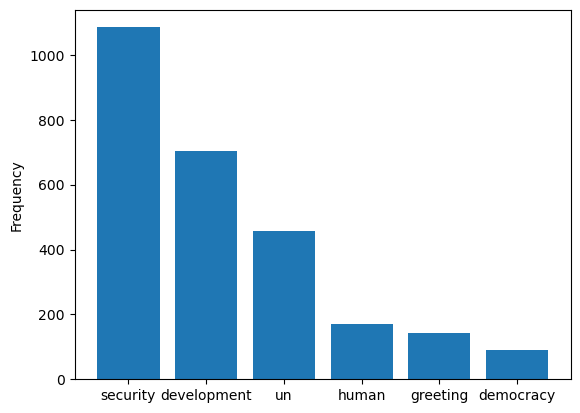

In [7]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

In [8]:
def load_sentences(data, type='train'):
  
  '''
    Extracts features and labels from dataset

  '''
  
  sentences, labels = [], []
  sentences = list(data['text'])

  if type == 'train':
    labels = list(data['coding'])
  sentences = [sentence.split('\t') for sentence in sentences]

  return sentences, labels

In [9]:
# Labelled Data
sentences, lables = load_sentences(labelled, 'train')

print('Training Sentences: ',len(sentences))
print('Training Labels: ',len(lables))
print('Training Example: ',sentences[0])

# Unlabelled Data
test_sentences, _ = load_sentences(final_unlabelled, 'test')

print('Testing Sentences: ',len(test_sentences))
print('Testing Example: ',test_sentences[16])

Training Sentences:  2650
Training Labels:  2650
Training Example:  ['I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.']
Testing Sentences:  2039133
Testing Example:  ['The so-called "European concert" is good proof of this concept which restricted the active access of the nonEuropean states to international life.']


In [10]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''
  def __init__(self, numbers=True, punct=True):
    self.numbers = numbers
    self.punct = punct

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)
    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

In [11]:
# Example of preprocessor class
print('Before: ', sentences[0][0])
processor = Preprocessor()
print('After: ', processor.apply(sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  i congratulate you sir on your election as president of the fortysixth session of the general assembly


In [12]:
def remove_stopwords(data):
  '''
    Removes Stopwords
    Tokenizes Sentences
    
  '''
  sentences = []
  split_sent = data.split()
  stopwords_set = set(stopwords.words('english'))
  sentences = [word for word in split_sent if word.lower() not in stopwords_set]
  return sentences

In [13]:
processor = Preprocessor()

# Labelled Data
clean_sentences = []
for idx, sentence in tqdm(enumerate(sentences)):
  clean_sentence = processor.apply(sentence[0])
  clean_sentences.append(remove_stopwords(clean_sentence))


# Unlabelled data
# test_clean_sentences = []
# for idx, sentence in tqdm(enumerate(test_sentences)):
#   clean_sentence = processor.apply(sentence[0])
#   test_clean_sentences.append(remove_stopwords(clean_sentence))

2650it [00:00, 8182.84it/s]


In [14]:
print('Example of a cleaned sentence')
print(clean_sentences[0])

Example of a cleaned sentence
['congratulate', 'sir', 'election', 'president', 'fortysixth', 'session', 'general', 'assembly']


In [15]:
# checking for empty sentences
def empty_sentences(data):
  
  '''
    Removes the sentences with less than 2 words
  '''
  print('Length before', len(data))

  sentences = [sublist for sublist in data if not all(elem == "" for elem in sublist)]
  train_sentences = []
  removed_indices = []
  removed_sentences = []
  train_indices=[]
  for idx, sentence in enumerate(sentences):
    if len(sentence) <= 2:
      removed_indices.append(idx)
      removed_sentences.append(sentence)
    else:
      train_sentences.append(sentence)
      train_indices.append(idx)
  print('Length after', len(train_sentences))
  
  return train_indices, train_sentences, removed_indices, removed_sentences

In [16]:
# Labelled Data
print("Labelled data")
train_indices, train_sentences, train_removed_indices, train_removed_sentences = empty_sentences(clean_sentences)


# Unlabelled data
# print("unlabelled data")
# test_sentences, test_indices, removed_test_sentences = empty_sentences(test_clean_sentences)

Labelled data
Length before 2650
Length after 2604


In [17]:
train_sentences[0]

['congratulate',
 'sir',
 'election',
 'president',
 'fortysixth',
 'session',
 'general',
 'assembly']

In [19]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

2023-04-28 21:53:46.488562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-28 21:53:46.489117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-28 21:53:46.489261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-28 21:53:46.489735: I tensorflow/core/

In [20]:
model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [21]:
def get_embeddings(sentences):
  preproc_text = preprocessor(sentences)
  return model(preproc_text)['pooled_output']


In [22]:
corpus_train_sent = []
for sentence in train_sentences:
  corpus_train_sent.append(" ".join(sentence))

In [23]:
corpus_train_sent[0]

'congratulate sir election president fortysixth session general assembly'

In [24]:
encoded_train = get_embeddings(corpus_train_sent)

In [25]:
encoded_train.shape

TensorShape([2604, 768])

In [26]:
encoded_labels = [labelled['coding'][i] for i in train_indices]
len(encoded_labels)

2604

In [27]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(encoded_labels)

In [31]:
encoded_labels[1:50]

array([2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 5,
       5, 5, 4, 4, 4])

In [32]:
### Model

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(1024, 512, 128, )).fit(encoded_train, encoded_labels)

In [39]:
preds = clf.predict(encoded_train)

In [56]:
clf.score(encoded_train, encoded_labels)

0.6351766513056836